In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib as plt
from itertools import chain
import ast

student_data = pd.read_csv("/Users/srisatyaindukuri/Spider/ML - Curricular Analytics - PIDM ONLY & Fixed Repeat IND.csv", low_memory=False)
grades = pd.read_csv("/Users/srisatyaindukuri/Spider/parsed_grades.csv")

student_data = student_data.drop(columns=['Admit_Term', 'Admit_Major_Code'])
student_data = student_data.dropna(subset=['Term', 'CRN', 'SUBJ', 'CRSE_NUMB', 'FINAL_GRADE'])

#Save latest student major
student_data['Term'] = student_data['Term'].astype(int)

last_sem_idx = student_data.groupby('Pidm')['Term'].idxmax()
latest_majors = student_data.loc[last_sem_idx, ['Pidm', 'Major_Desc']]
majors_dict = latest_majors.set_index('Pidm')['Major_Desc'].to_dict()
student_data['Lastest_Major'] = student_data['Pidm'].map(majors_dict)
student_data = student_data.drop(columns=['Major_Desc'])
student_data.drop_duplicates(subset=['Pidm', 'Term', 'CRN'], inplace=True)


# Merge the two dataframes to bring in the Quality Points and whether to count in GPA
student_data = pd.merge(student_data, grades[['Code', 'Quality Points', 'Count in GPA?']], 
              left_on='FINAL_GRADE', right_on='Code', how='left', suffixes=('', '_grades'))

# Fill missing 'Quality Points' with 0.0 for unrecognized grades
student_data['Quality Points'] = student_data['Quality Points'].fillna(0.0)
student_data['Count_in_GPA'] = student_data['Count in GPA?'] == 'Y'

#Final and Semester GPAs (Assuming all classes are equal credits)
student_data['Valid_Grades'] = np.where(student_data['Count in GPA?'] == 'Y' , student_data['Quality Points'], np.nan)
student_final_gpa = student_data.groupby('Pidm')['Valid_Grades'].mean().reset_index()
student_data = student_data.merge(student_final_gpa, on='Pidm', how='left', suffixes=('', '_mean'))
student_data.rename(columns={'Valid_Grades_mean':'Final GPA'}, inplace=True)

student_semester_gpa = student_data.groupby(['Pidm', 'Term'])['Valid_Grades'].mean().reset_index()
student_data = student_data.merge(student_semester_gpa, on=['Pidm', 'Term'], how='left', suffixes=('', '_mean'))
student_data.rename(columns={'Valid_Grades_mean':'Semester GPA'}, inplace=True)


#Student Classes & Points per Semester (As an array of strings)
student_data['class'] = (student_data['SUBJ'] + student_data['CRSE_NUMB']).astype(str)
semester_classes = student_data.groupby(['Pidm', 'Term']).agg({
    'FINAL_GRADE': list,
    'Quality Points': list, 
    'class': list,
    'CRN': list,
}).reset_index()

#Drop unecessary columns
student_data.drop(['SUBJ', 'REPEAT_IND', 'FINAL_GRADE', 'class', 'Code', 'Count in GPA?', 'Count_in_GPA', 'Valid_Grades'], axis=1, inplace=True)

#Remove repeated rows in the demographic columns
student_data = student_data.groupby(['Pidm', 'Term']).agg({ 
    'Admit_Level': 'first', 
    'Admit_College': 'first',
    'Lastest_Major': 'first',
    'Trump_Race': 'first', 
    'Trump_Race_Desc': 'first', 
    'MULTI': 'first', 
    'Race': 'first', 
    'NEW_ETHNICITY': 'first', 
    'GENDER_Code': 'first', 
    'GENDER': 'first', 
    'CITZ_IND': 'first', 
    'CITZ_CODE': 'first', 
    'CITZ_DESC': 'first', 
    'Final_GPA': 'first', 
    'ACTE': 'first', 
    'ACTM': 'first', 
    'ACTR': 'first', 
    'ACTS': 'first', 
    'EACT': 'first', 
    'SAT-ERW': 'first', 
    'SATM': 'first', 
    'SAT_TOTAL': 'first', 
    'Final GPA': 'first',
    'Semester GPA': 'first'
}).reset_index()

#Add Semester grades and gpa points to df
student_data = student_data.merge(semester_classes[['Pidm', 'Term', 'FINAL_GRADE', 'Quality Points', 'class', 'CRN']], on=['Pidm', 'Term'], how='left')
student_data.rename(columns={'Final_GPA':'HS GPA', 'Term':'Semester','FINAL_GRADE':'Semester Grades', 'Quality Points':'Semester Points', 'class':'Classes'}, inplace=True)

###Code from Varma to convert SATs
# List of score columns
score_columns = ['ACTE', 'ACTM', 'ACTR', 'ACTS', 'EACT', 'SAT-ERW', 'SATM', 'SAT_TOTAL', 'HS GPA']

# Convert score columns to numeric
for col in score_columns:
    student_data[col] = pd.to_numeric(student_data[col], errors='coerce')

# ACT to SAT conversion table
act_to_sat_conversion = {
    36: 1590, 35: 1540, 34: 1500, 33: 1460, 32: 1430, 31: 1400,
    30: 1370, 29: 1340, 28: 1310, 27: 1280, 26: 1240, 25: 1210,
    24: 1180, 23: 1140, 22: 1110, 21: 1080, 20: 1040, 19: 1010,
    18: 970, 17: 930, 16: 890, 15: 850, 14: 800, 13: 760,
    12: 710, 11: 670, 10: 630, 9: 590
}

# Convert EACT to SAT
def convert_act_to_sat(eact_score):
    if pd.isna(eact_score):
        return np.nan
    return act_to_sat_conversion.get(int(eact_score), np.nan)

# Apply the conversion to EACT scores
student_data['Converted_SAT'] = student_data['SAT_TOTAL']

# Identify where SAT_TOTAL is missing but EACT is available
mask = student_data['SAT_TOTAL'].isna() & student_data['EACT'].notna()

# Apply conversion
student_data.loc[mask, 'Converted_SAT'] = student_data.loc[mask, 'EACT'].apply(convert_act_to_sat)

# Step 4: Handle Remaining Missing Values

# Drop rows where Converted_SAT or Final_GPA is still NaN
student_data = student_data.dropna(subset=['Converted_SAT', 'HS GPA'])

#Correct datatypes and output to csv
student_data = student_data.astype(str)
student_data['Pidm'] = student_data['Pidm'].astype(int)
student_data['Final GPA'] = student_data['Final GPA'].astype(float).round(2)
student_data['Semester GPA'] = student_data['Semester GPA'].astype(float).round(2)
student_data['Semester'] = student_data['Semester'].astype(float).astype(int).astype(str)

#Split into train-dev-test sets by Pidm
student_ids = student_data['Pidm'].unique()
train, testing_data = train_test_split(student_ids, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)
train_set = student_data[student_data['Pidm'].isin(train)]
dev_set = student_data[student_data['Pidm'].isin(dev)]
test_set = student_data[student_data['Pidm'].isin(test)]

#Output to .csv
student_data.to_csv("full_set.csv", index=False)
train_set.to_csv("train_set.csv", index=False)
dev_set.to_csv("dev_set.csv", index=False)
test_set.to_csv("test_set.csv", index=False)

In [2]:
df = pd.read_csv("full_set.csv")
df.shape

(588793, 31)

In [3]:
TARGET_CLASS = "CHM2210"
# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)
# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes
127,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]"
128,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101]
129,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]"
130,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]"


In [4]:
# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename(f'{TARGET_CLASS}_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df[f'{TARGET_CLASS}_Semester']]
# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = [f'{TARGET_CLASS}_Points', f'{TARGET_CLASS}_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df[f'{TARGET_CLASS}_Grade'].isin(['WE', 'IF', 'W', 'WC'])]
display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df[f'{TARGET_CLASS}_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    f'{TARGET_CLASS}_Grade': 'first',
    f'{TARGET_CLASS}_Points': 'first',
}).reset_index()

/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_22697/152530786.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename(f'{TARGET_CLASS}_Semester')
/var/folders/1_/f10h6scn5x19_qnf0xw8fpyr0000gn/T/ipykernel_22697/152530786.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').a

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,CHM2210_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,CHM2210_Semester,CHM2210_Points,CHM2210_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


In [5]:
all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])
print(set(groupped_df["CHM2210_Grade"]))

{'D*', 'F*', 'S', 'C', 'A', 'U', 'C-', 'C*', 'D', 'D+', 'C+', 'CF', 'CM', 'A-*', 'FF', 'B+', 'A-', 'B-*', 'CC-', 'B-', 'A+', 'C-*', 'B', 'F', 'D-'}


In [6]:
print(groupped_df.shape)
display(groupped_df.head(3))

print(one_hot_df.shape)
display(one_hot_df.head(3))

(11781, 10)


,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,CHM2210_Grade,CHM2210_Points,One_Hot_Classes
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


(11781, 1524)


,ACG2021,ACG2071,ACG3074,ACG3103,ACG3113,ACG3341,ACG3401,ACG4123,ACG4632,ACG4684,ACG5205,ADV2214,ADV3008,AFA2000,AFA2380,AFA3110,AFA4150,AFA4335,AFA4430,AFA4931,AFH3100,AFH3200,AFR1101,AFR1120,AFR2001,AFR2130,AFR2140,AFR3220,AFR3231,AFR4201,AFS2250,AMH2010,AMH2020,AMH3130,AMH3140,AMH3160,AMH3170,AMH3270,AMH3390,AMH3402,AMH3403,AMH3421,AMH3423,AMH3533,AMH3545,AMH3571,AMH3572,AML3031,AML3051,AML3243,AML3604,AML3630,AML3674,AML4111,AMS2030,AMS2270,AMS3700,AMS3930,AMS4804,ANS3006,ANT2000,ANT2410,ANT2464,ANT2511,ANT2511L,ANT2721,ANT3005,ANT3101,ANT3610,ANT4012,ANT4034,ANT4167,ANT4241,ANT4302,ANT4316,ANT4401,ANT4403,ANT4442,ANT4462,ANT4465,ANT4468,ANT4516,ANT4520C,ANT4525,ANT4532,ANT4536,ANT4593,ANT4701,ANT4750,ANT4824,ANT4905,ANT4930,APK3120,APK4138C,APK6109,APK6511,APK6902,ARA1120,ARA1121,ARC2112L,ARC2131C,ARC2135C,ARC2180,ARC2211,ARC2701,ARC2702,ARC2931,ARC4784,ARC5361,ARC5362,ARC5470,ARC5587,ARC5732,ARC5931,ARH2000,ARH2050,ARH2051,ARH3001,ARH4301,ARH4333,ARH4450,ARH4890,ARH4930,ART2201C,ART2203C,ART2301C,ART2344,ART2500C,ART2701C,ART2750C,ART2930,ART3530C,ART3612C,ART3616C,ART4814,ART4905,ART4930,ART4940,ASL2140C,ASL2150C,ASL3514,ASL4161C,ASL4201C,ASL4301C,ASN3012,ASN3014,ASN3030,ASN3201,ASN4414,AST2002,AST2003,AST2004,AST3033,AST3044,AST3930,ATR1000,ATR2010C,ATR3132,BCH3023L,BCH3053,BCH4033,BME3053,BME4100,BME4406,BME4503,BME4508,BME4571,BME4914,BME4931,BME4943,BOT3015C,BOT3152C,BOT3850,BOT4404C,BOT4714C,BOT4851,BSC1005,BSC1020,BSC2010,BSC2010L,BSC2011,BSC2011L,BSC2050,BSC2085,BSC2085L,BSC2086,BSC2086L,BSC2093C,BSC2094C,BSC2932,BSC3022,BSC3312,BSC3368C,BSC3402L,BSC3453,BSC3848,BSC4052,BSC4057,BSC4313C,BSC4315,BSC4333,BSC4444,BSC4454C,BSC4511,BSC4905,BSC4910,BSC4933,BSC4940,BUL3320,CBH4004,CCJ3014,CCJ3024,CCJ3026,CCJ3058,CCJ3117,CCJ3120,CCJ3621,CCJ3632,CCJ3644,CCJ3666,CCJ3701,CCJ3718,CCJ4072,CCJ4361,CCJ4487,CCJ4604,CCJ4613,CCJ4651,CCJ4662,CCJ4681,CCJ4930,CCJ4933,CCJ4934,CDA3103,CDA3201,CDA3201L,CEN3722,CGN4122,CGN4905,CGN4933,CGS1540,CGS2034,CGS2060,CGS2094,CGS2100,CGS3303,CGS3853,CHI1100,CHI1120,CHI1121,CHI1955,CHI2220,CHI2221,CHI3241,CHI3242,CHI4930,CHM2020,CHM2023,CHM2045,CHM2045L,CHM2046,CHM2046L,CHM2210L,CHM2211,CHM3080,CHM3120C,CHM3415C,CHM3610,CHM3610L,CHM3941,CHM4060,CHM4070,CHM4410,CHM4932,CHM4970,CHS2440,CHS2440L,CHS4411,CHT3512,CIS3213,CIS3360,CIS3362,CIS3433,CIS3615,CIS4083,CIS4204,CJC4010,CJE3213,CJE3444,CJE3650,CJE3656,CJE3701,CJE4010,CJE4114,CJE4731,CJL3110,CJL3502,CJL4115,CJL4410,CLA3103,CLA3124,CLA3503,CLA3930,CLP4134,CLP4143,CLP4314,CLP4414,CLP4433,CLP4941,CLT3040,CLT3103,CLT3123,CLT3370,CNT4104,CNT4104L,CNT4403,CNT4603,COM2000,COM2130,COM3014,COM3122,COM4022,COM4027,COM4030,COM4374,COP2030,COP2250,COP2510,COP2512,COP2513,COP2931,COP3331,COP3353,COP3514,COP3515,COP4313,COP4530,COP4538,COP4703,COP4931,COT3100,CPO2002,CPO4034,CPO4930,CRW2100,CRW3013,CRW3111,CRW3112,CRW3121,CRW3311,CRW3312,CRW3321,CRW4930,DAA2100,DAA2104,DAA2200,DAA2204,DAA2500,DAA3108,DAA3209,DAA3214,DAA3294,DAA3395,DAA3614,DAA3615,DAA3624,DAA4211,DAN2100,DAN2160,DAN3584,DAN3615,DAN3714,DAN4134,DAN4434,DAN4906,DEP2004,DEP4053,DEP4220,DIG3950C,ECH3002,ECH3023,ECH3101,ECH3240L,ECH3266,ECH3702,ECH3783,ECH3854,ECH4123,ECH4241L,ECH4267,ECH4323,ECH4418,ECH4504,ECH4605,ECH4615,ECH4615C,ECH4680C,ECH4715,ECH4783,ECH4846,ECH4905,ECH4931,ECH4936,ECH4944,ECO1000,ECO2013,ECO2023,ECO2052,ECO3101,ECO3203,ECO3703,ECO4303,ECO4400,ECO4914,ECO4935,ECP3302,ECP3530,ECS3013,ECS4003,EDE4223,EDE4323,EDE4504,EDE4941,EDF2005,EDF2085,EDF3132,EDF3214,EDF3228,EDF3514,EDF3604,EDF4124,EDF4430,EDF4440,EDF4490,EDF6211,EDG2930,EDG3361,EDG3801,EDG4012,EDG4909,EDP2210,EDP3273,EEE3302,EEE3394,EEE4506,EEL2161,EEL3472C,EEL3705,EEL3705L,EEL4705,EEL4935,EEL4936,EEL6935,EEX4012,EEX4070,EEX4742,EGN1113,EGN3000,EGN3000L,EGN3311,EGN3321,EGN3331,EGN3343,EGN3353,EGN3365,EGN3373,EGN3374,EGN3420,EGN3433,EGN3443,EGN3615,EGN3940,EGN4450,EGN4453,EGN4905,EGN4930,EGS2070,EGS3011,EGS3720,EIN4172,EIN4451,EIN4933,EMA4003,EME2040,EME4390,EML3022,EML3035,EML3041,EML3262,EML3303,EML3500,EML3701,EML4106C,E

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [8]:
groupped_df.replace(-1, np.nan, inplace=True)

In [9]:
if 'one_hot_vector' in groupped_df.columns:
    # Convert string representation of lists to actual lists
    groupped_df['one_hot_vector'] = groupped_df['one_hot_vector'].apply(ast.literal_eval)
    
    # Expand the list into separate columns
    one_hot_expanded = pd.DataFrame(groupped_df['one_hot_vector'].tolist(), index=groupped_df.index)
    
    # Rename one-hot columns if necessary
    # For example, if you know the number of classes, you can name them accordingly
    one_hot_expanded.columns = [f'one_hot_{i}' for i in range(one_hot_expanded.shape[1])]
    
    # Concatenate the expanded one-hot columns back to the main DataFrame
    groupped_df = pd.concat([groupped_df.drop('one_hot_vector', axis=1), one_hot_expanded],axis=1)

In [10]:
def map_pass_fail(grade):
    fail_grades = failing_grades = ['F', 'IF', 'W','D-', 'F', 'D+', 'D#', 'D+', 'F#', 'D', 'D', 'D-','U','W','F*','D*','CF','I','FF','Z','W*', 'F+', 'F-', 'F#', 'F*','D-*','IF','IF*', 'D+*','CIF','Z*', 'IU','M', 'CI', 'MU', 'U*', 'ID', 'IB', 'IU*', 'IS', 'CW']
    if grade in fail_grades:
        return 0  # Pass
    else:
        return 1  # Fail

In [11]:
# Apply the mapping
groupped_df['pass_fail'] = groupped_df['CHM2210_Grade'].apply(map_pass_fail)

In [12]:
groupped_df.head(5)

,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,CHM2210_Grade,CHM2210_Points,One_Hot_Classes,pass_fail
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",0
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1
3,1096567,3.85,1340.0,"[A-, A-, B-, W, A+, D, B, A+, B+, B, A, A+, A-...","[3.67, 3.67, 2.67, 0.0, 4.0, 1.0, 3.0, 4.0, 3....","[MAC1147, ENC1102, CHM2045, CHM2045L, SLS2901,...","[82970.0, 89553.0, 92762.0, 92839.0, 93253.0, ...",C,2.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1
4,1302110,2.43,1040.0,[A],[4.0],[PCB3063],[54321.0],A+,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...",1


In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import resample
import pandas as pd

# Assuming 'groupped_df' and 'one_hot_df' are already defined and contain the relevant data.

# Merge the datasets
merged_df = pd.merge(groupped_df, one_hot_df, left_on='Pidm', right_index=True)

# Drop columns with lists or irrelevant features
X = merged_df.drop(columns=['Pidm', 'CHM2210_Grade', 'CHM2210_Points', 'Semester Grades', 'Semester Points', 'Classes', 'CRN', 'One_Hot_Classes', 'pass_fail'])

# Convert any remaining object columns to numerical if necessary
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values, as AdaBoost can't handle NaNs
X = X.dropna()

# Separate majority and minority classes for undersampling
df_majority = merged_df[merged_df['pass_fail'] == 1]  # Assuming 0 represents 'fail'
df_minority = merged_df[merged_df['pass_fail'] == 0]  # Assuming 1 represents 'pass'

# Downsample majority class to match the size of the minority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,     # sample without replacement
                                   n_samples=len(df_minority),  # match minority class count
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Separate features and target variable from balanced data
X = df_balanced.drop(columns=['Pidm', 'CHM2210_Grade', 'CHM2210_Points', 'Semester Grades', 'Semester Points', 'Classes', 'CRN', 'One_Hot_Classes', 'pass_fail'])
X = X.apply(pd.to_numeric, errors='coerce').dropna()  # Ensure all are numeric and remove NaNs
y = df_balanced['pass_fail'].loc[X.index]  # Align target with features

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}

# Initialize AdaBoost classifier
ada_classifier = AdaBoostClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=ada_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

Best parameters found: {'learning_rate': 1, 'n_estimators': 50}


In [25]:
# --- Make sure all necessary imports are at the top of your script ---
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Your existing code ---
# 'grid_search' is assumed to be a fitted GridSearchCV/RandomizedSearchCV object
best_ada_classifier = grid_search.best_estimator_

# Get standard predictions (for CM, Accuracy, Report)
y_pred = best_ada_classifier.predict(X_test)

# Get prediction probabilities (for AUROC, ROC Curve, P-R Curve)
y_pred_proba = best_ada_classifier.predict_proba(X_test)

# --- START: Standard Evaluation ---
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("--- Standard Evaluation ---")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix (AdaBoost)')
plt.savefig('adaboost_confusion_matrix.png')
plt.close()
print("Confusion Matrix plot saved to 'adaboost_confusion_matrix.png'")
# --- END: Standard Evaluation ---


# --- START: Probability-Based Evaluation (AUROC, P-R) ---
print("\n--- Advanced Metrics ---")

# Get model classes and binarize y_test
model_classes = best_ada_classifier.classes_
n_classes = len(model_classes)
y_test_bin = label_binarize(y_test, classes=model_classes)

# --- Fix 1: Correct AUROC computation for binary/multi-class ---
if n_classes == 2:
    auroc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
else:
    auroc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')

print(f"Macro-Averaged AUROC: {auroc_score:.4f}")

# --- Plot AUC-ROC Curves (One-vs-Rest) ---
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

if n_classes == 2:
    # Binary classification (flatten binarized labels)
    y_test_bin = y_test_bin.ravel()
    fpr["binary"], tpr["binary"], _ = roc_curve(y_test_bin, y_pred_proba[:, 1])
    roc_auc["binary"] = auc(fpr["binary"], tpr["binary"])
    plt.plot(fpr["binary"], tpr["binary"], color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc["binary"]:.2f})')
else:
    # Multi-class case
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {model_classes[i]} (area = {roc_auc[i]:.2f})')

# Optional macro-average ROC for multi-class
if n_classes > 2:
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc["macro"] = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--', lw=2,
             label=f'Macro-average ROC (area = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('adaboost_auc_roc_curves.png')
plt.close()
print("AUC-ROC curve plot saved to 'adaboost_auc_roc_curves.png'")

# --- Plot Precision-Recall Curves (One-vs-Rest) ---
precision = dict()
recall = dict()
average_precision = dict()

plt.figure(figsize=(10, 8))

# --- Fix 2: Robust handling for binary/multi-class ---
if n_classes == 2:
    y_test_bin = y_test_bin.ravel()
    precision["binary"], recall["binary"], _ = precision_recall_curve(y_test_bin, y_pred_proba[:, 1])
    average_precision["binary"] = average_precision_score(y_test_bin, y_pred_proba[:, 1])
    plt.plot(recall["binary"], precision["binary"], color='blue', lw=2,
             label=f'P-R curve (AP = {average_precision["binary"]:.2f})')
else:
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {model_classes[i]} (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.savefig('adaboost_precision_recall_curves.png')
plt.close()
print("Precision-Recall curve plot saved to 'adaboost_precision_recall_curves.png'")
# --- END: Probability-Based Evaluation ---


--- Standard Evaluation ---
Accuracy: 74.62%

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.75       420
           1       0.77      0.71      0.74       427

    accuracy                           0.75       847
   macro avg       0.75      0.75      0.75       847
weighted avg       0.75      0.75      0.75       847


Confusion Matrix:
 [[327  93]
 [122 305]]
Confusion Matrix plot saved to 'adaboost_confusion_matrix.png'

--- Advanced Metrics ---


ValueError: y should be a 1d array, got an array of shape (847, 2) instead.

In [ ]:
X_train.head(5)

,HS GPA,Converted_SAT,ACG2021,ACG2071,ACG3074,ACG3103,ACG3113,ACG3341,ACG3401,ACG4123,ACG4632,ACG4684,ACG5205,ADV2214,ADV3008,AFA2000,AFA2380,AFA3110,AFA4150,AFA4335,AFA4430,AFA4931,AFH3100,AFH3200,AFR1101,AFR1120,AFR2001,AFR2130,AFR2140,AFR3220,AFR3231,AFR4201,AFS2250,AMH2010,AMH2020,AMH3130,AMH3140,AMH3160,AMH3170,AMH3270,AMH3390,AMH3402,AMH3403,AMH3421,AMH3423,AMH3533,AMH3545,AMH3571,AMH3572,AML3031,AML3051,AML3243,AML3604,AML3630,AML3674,AML4111,AMS2030,AMS2270,AMS3700,AMS3930,AMS4804,ANS3006,ANT2000,ANT2410,ANT2464,ANT2511,ANT2511L,ANT2721,ANT3005,ANT3101,ANT3610,ANT4012,ANT4034,ANT4167,ANT4241,ANT4302,ANT4316,ANT4401,ANT4403,ANT4442,ANT4462,ANT4465,ANT4468,ANT4516,ANT4520C,ANT4525,ANT4532,ANT4536,ANT4593,ANT4701,ANT4750,ANT4824,ANT4905,ANT4930,APK3120,APK4138C,APK6109,APK6511,APK6902,ARA1120,ARA1121,ARC2112L,ARC2131C,ARC2135C,ARC2180,ARC2211,ARC2701,ARC2702,ARC2931,ARC4784,ARC5361,ARC5362,ARC5470,ARC5587,ARC5732,ARC5931,ARH2000,ARH2050,ARH2051,ARH3001,ARH4301,ARH4333,ARH4450,ARH4890,ARH4930,ART2201C,ART2203C,ART2301C,ART2344,ART2500C,ART2701C,ART2750C,ART2930,ART3530C,ART3612C,ART3616C,ART4814,ART4905,ART4930,ART4940,ASL2140C,ASL2150C,ASL3514,ASL4161C,ASL4201C,ASL4301C,ASN3012,ASN3014,ASN3030,ASN3201,ASN4414,AST2002,AST2003,AST2004,AST3033,AST3044,AST3930,ATR1000,ATR2010C,ATR3132,BCH3023L,BCH3053,BCH4033,BME3053,BME4100,BME4406,BME4503,BME4508,BME4571,BME4914,BME4931,BME4943,BOT3015C,BOT3152C,BOT3850,BOT4404C,BOT4714C,BOT4851,BSC1005,BSC1020,BSC2010,BSC2010L,BSC2011,BSC2011L,BSC2050,BSC2085,BSC2085L,BSC2086,BSC2086L,BSC2093C,BSC2094C,BSC2932,BSC3022,BSC3312,BSC3368C,BSC3402L,BSC3453,BSC3848,BSC4052,BSC4057,BSC4313C,BSC4315,BSC4333,BSC4444,BSC4454C,BSC4511,BSC4905,BSC4910,BSC4933,BSC4940,BUL3320,CBH4004,CCJ3014,CCJ3024,CCJ3026,CCJ3058,CCJ3117,CCJ3120,CCJ3621,CCJ3632,CCJ3644,CCJ3666,CCJ3701,CCJ3718,CCJ4072,CCJ4361,CCJ4487,CCJ4604,CCJ4613,CCJ4651,CCJ4662,CCJ4681,CCJ4930,CCJ4933,CCJ4934,CDA3103,CDA3201,CDA3201L,CEN3722,CGN4122,CGN4905,CGN4933,CGS1540,CGS2034,CGS2060,CGS2094,CGS2100,CGS3303,CGS3853,CHI1100,CHI1120,CHI1121,CHI1955,CHI2220,CHI2221,CHI3241,CHI3242,CHI4930,CHM2020,CHM2023,CHM2045,CHM2045L,CHM2046,CHM2046L,CHM2210L,CHM2211,CHM3080,CHM3120C,CHM3415C,CHM3610,CHM3610L,CHM3941,CHM4060,CHM4070,CHM4410,CHM4932,CHM4970,CHS2440,CHS2440L,CHS4411,CHT3512,CIS3213,CIS3360,CIS3362,CIS3433,CIS3615,CIS4083,CIS4204,CJC4010,CJE3213,CJE3444,CJE3650,CJE3656,CJE3701,CJE4010,CJE4114,CJE4731,CJL3110,CJL3502,CJL4115,CJL4410,CLA3103,CLA3124,CLA3503,CLA3930,CLP4134,CLP4143,CLP4314,CLP4414,CLP4433,CLP4941,CLT3040,CLT3103,CLT3123,CLT3370,CNT4104,CNT4104L,CNT4403,CNT4603,COM2000,COM2130,COM3014,COM3122,COM4022,COM4027,COM4030,COM4374,COP2030,COP2250,COP2510,COP2512,COP2513,COP2931,COP3331,COP3353,COP3514,COP3515,COP4313,COP4530,COP4538,COP4703,COP4931,COT3100,CPO2002,CPO4034,CPO4930,CRW2100,CRW3013,CRW3111,CRW3112,CRW3121,CRW3311,CRW3312,CRW3321,CRW4930,DAA2100,DAA2104,DAA2200,DAA2204,DAA2500,DAA3108,DAA3209,DAA3214,DAA3294,DAA3395,DAA3614,DAA3615,DAA3624,DAA4211,DAN2100,DAN2160,DAN3584,DAN3615,DAN3714,DAN4134,DAN4434,DAN4906,DEP2004,DEP4053,DEP4220,DIG3950C,ECH3002,ECH3023,ECH3101,ECH3240L,ECH3266,ECH3702,ECH3783,ECH3854,ECH4123,ECH4241L,ECH4267,ECH4323,ECH4418,ECH4504,ECH4605,ECH4615,ECH4615C,ECH4680C,ECH4715,ECH4783,ECH4846,ECH4905,ECH4931,ECH4936,ECH4944,ECO1000,ECO2013,ECO2023,ECO2052,ECO3101,ECO3203,ECO3703,ECO4303,ECO4400,ECO4914,ECO4935,ECP3302,ECP3530,ECS3013,ECS4003,EDE4223,EDE4323,EDE4504,EDE4941,EDF2005,EDF2085,EDF3132,EDF3214,EDF3228,EDF3514,EDF3604,EDF4124,EDF4430,EDF4440,EDF4490,EDF6211,EDG2930,EDG3361,EDG3801,EDG4012,EDG4909,EDP2210,EDP3273,EEE3302,EEE3394,EEE4506,EEL2161,EEL3472C,EEL3705,EEL3705L,EEL4705,EEL4935,EEL4936,EEL6935,EEX4012,EEX4070,EEX4742,EGN1113,EGN3000,EGN3000L,EGN3311,EGN3321,EGN3331,EGN3343,EGN3353,EGN3365,EGN3373,EGN3374,EGN3420,EGN3433,EGN3443,EGN3615,EGN3940,EGN4450,EGN4453,EGN4905,EGN4930,EGS2070,EGS3011,EGS3720,EIN4172,EIN4451,EIN4933,EMA4003,EME2040,EME4390,EML3022,EML3035,EML3041,EML3262,EML3303,EML35

In [ ]:
y_train.head(5)

2158    1
298     0
9865    0
7444    0
7846    1
Name: pass_fail, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the feature importances from the AdaBoost classifier
feature_importances = best_ada_classifier.feature_importances_

# Get the column names (features)
feature_names = X.columns

# Pair the feature names with their corresponding importances
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Convert to a DataFrame for easy display and access
feature_importance_df = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Display the feature importances as a DataFrame
print("Feature Importances (sorted):")
print(feature_importance_df)

Feature Importances (sorted):
       Feature  Importance
0      CHM2046    0.351566
1      CHM2045    0.130874
2     BSC2010L    0.094830
3      BSC2011    0.090423
4      PCB3063    0.078565
...        ...         ...
1521  ZOO4307L    0.000000
1522   ZOO4454    0.000000
1523   ZOO4512    0.000000
1524   ZOO4513    0.000000
1525   ZOO4694    0.000000

[1526 rows x 2 columns]


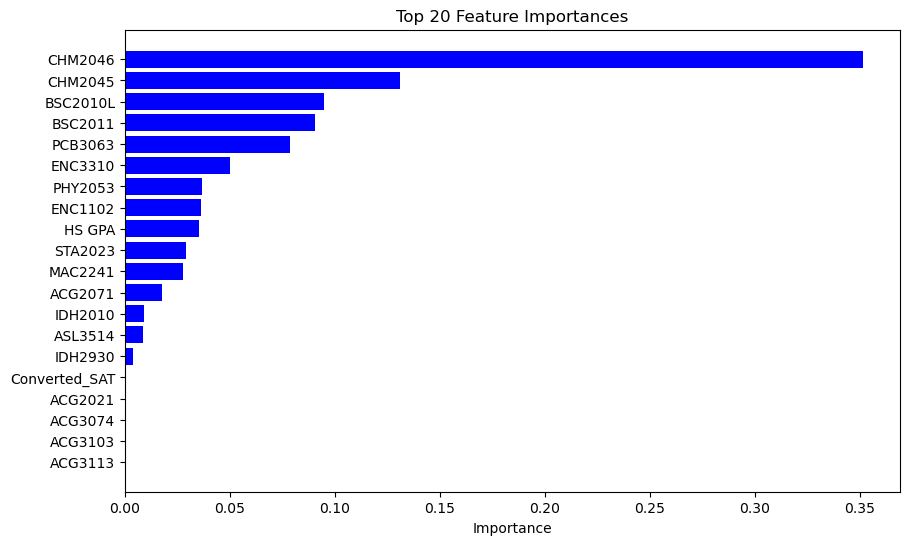

In [ ]:
# Plotting the top 20 features for visualization
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
top_features = feature_importance_df.head(20)  # Plot the top 20 features
plt.barh(top_features['Feature'], top_features['Importance'], color='b')
plt.xlabel("Importance")
plt.gca().invert_yaxis()  # To display the highest at the top
plt.show()

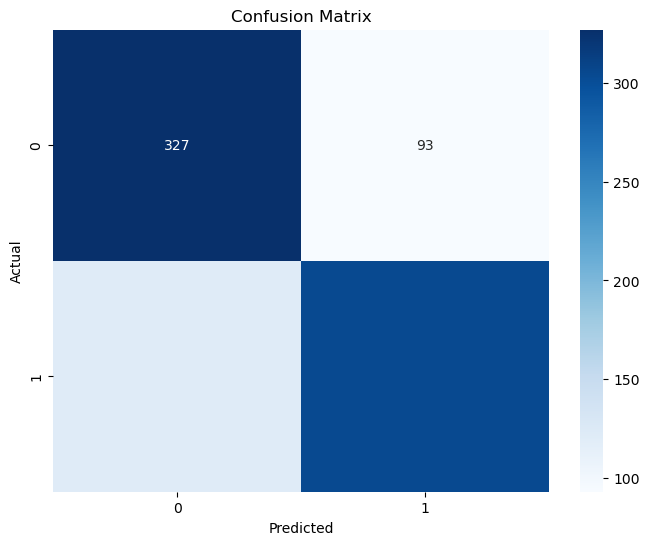

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the Gradient Boosting model
gb_classifier.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_classifier.predict(X_test)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb)

print(f"Accuracy: {accuracy_gb * 100:.2f}%")
print("Classification Report:\n", classification_rep_gb)

Accuracy: 76.27%
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       420
           1       0.78      0.74      0.76       427

    accuracy                           0.76       847
   macro avg       0.76      0.76      0.76       847
weighted avg       0.76      0.76      0.76       847



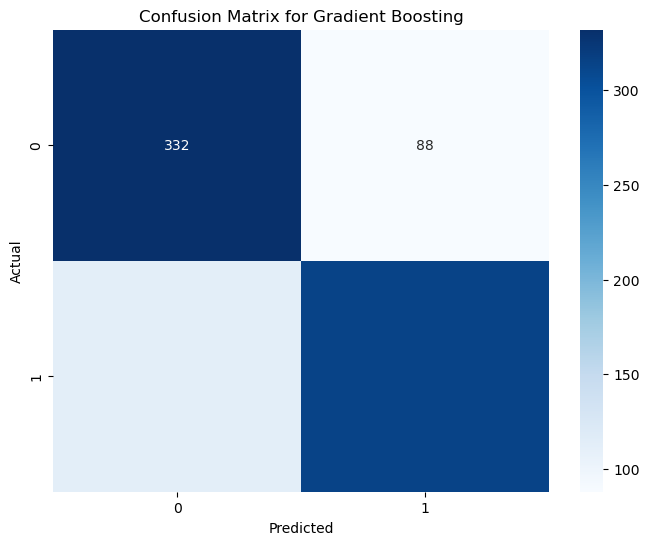

In [ ]:
# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_gb, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()

In [ ]:
# Get feature importances
feature_importances = gb_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:\n", feature_importances_df)


Feature Importances:
        Feature  Importance
262    CHM2046    0.503002
260    CHM2045    0.059771
0       HS GPA    0.045729
182    BSC2011    0.044782
181   BSC2010L    0.031138
...        ...         ...
614    GEB3033    0.000000
613    GEB2935    0.000000
612    GEB2011    0.000000
611    GEA2000    0.000000
1525   ZOO4694    0.000000

[1526 rows x 2 columns]


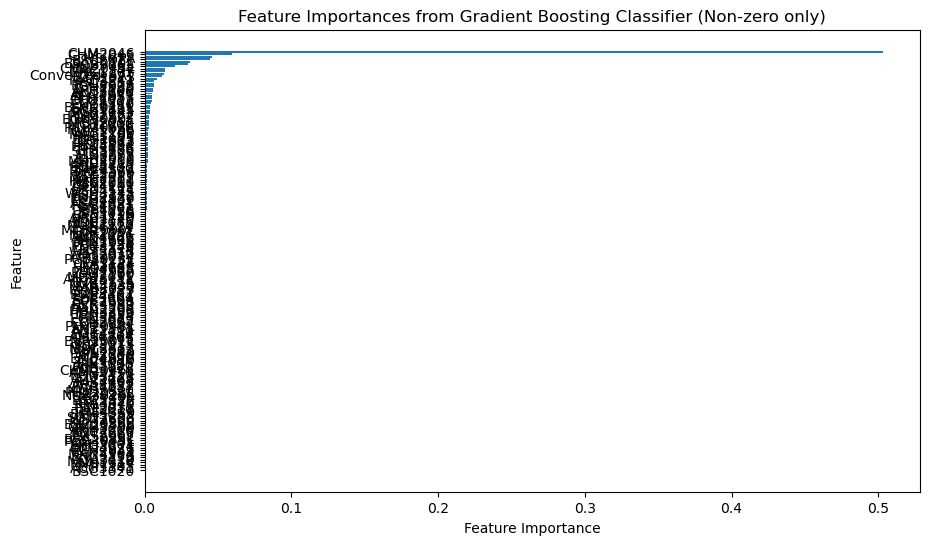

In [ ]:
# Filter the DataFrame to include only features with importance greater than 0
feature_importances_nonzero = feature_importances_df[feature_importances_df['Importance'] > 0]

# Plot the non-zero feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_nonzero['Feature'], feature_importances_nonzero['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Gradient Boosting Classifier (Non-zero only)")
plt.gca().invert_yaxis()
plt.show()